In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/database.sqlite


# Data Preprocessing

In [20]:
# read csv file

input_directory = '../input/amazon-fine-food-reviews/Reviews.csv'
df = pd.read_csv(input_directory)

In [ ]:
df.head()

In [21]:
df = df[['Text', 'Score']]
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [22]:
df.shape

(568454, 2)

In [23]:
# Clean rows with nan text and drop all columns except text and category
# df = df.dropna(subset=['text']).iloc[:, [1, 3]]
df.dropna(subset=['Text'])

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
568449,Great for sesame chicken..this is a good if no...,5
568450,I'm disappointed with the flavor. The chocolat...,2
568451,"These stars are small, so you can give 10-15 o...",5
568452,These are the BEST treats for training and rew...,5


In [24]:
df.shape

(568454, 2)

In [25]:
# import string
# tweet = "I am tired! I like fruit...and milk"
# translator = str.maketrans(string.punctuation + '–', ' '*len(string.punctuation + '–')) #map punctuation to space
# print(tweet.translate(translator))
review = "i am a bangladeshi. i love football. i love math.. some day i will go to mars."
t = review.split('.')
print(t) 
t = review.split('.')[:-1]
print(t)

['i am a bangladeshi', ' i love football', ' i love math', '', ' some day i will go to mars', '']
['i am a bangladeshi', ' i love football', ' i love math', '', ' some day i will go to mars']


In [26]:
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [30]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class ReviewsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for review in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
#             print(review)
            review =  review.lower()
            
            #[:-1] means 0 to n-1 column. cause last element after the last full stop is null. 
            for sentence in review.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words
                
sentences = ReviewsIterator(df)

In [ ]:
# next(sentences)

# FastText Model

In [31]:
# Import everything that will be used
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt

In [32]:
# Train Word2Vec model with gensim on the dataset
w2v_model = gensim.models.FastText(sentences, size=100, window=5, min_count=10, workers=8)

In [33]:
w2v_model.save('fasttext_trained_model')


In [34]:
fasttext_model = gensim.models.FastText.load('fasttext_trained_model')

In [35]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later

ft_weights = fasttext_model.wv.vectors

In [36]:
vocab_size, embedding_size = ft_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 34867 - Embedding Dim: 100


In [37]:
# fasttext_model.wv.most_similar('good')
# ft_weights
fasttext_model['good']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-3.0968802 , -2.8504052 ,  1.2101833 , -3.2441878 , -3.9731333 ,
        3.098405  , -3.1624696 , -1.1136851 , -2.7347922 ,  1.5297512 ,
        1.2459581 ,  0.67667603, -2.707384  ,  1.5748909 ,  2.235286  ,
       -1.391121  , -4.5987644 , -0.06928376, -4.2744823 ,  2.0869555 ,
       -1.3815999 , -0.452874  , -5.6586723 ,  4.2224927 ,  1.761424  ,
       -0.71970373, -1.5017551 , -0.6103146 , -1.8945549 ,  0.6092402 ,
       -2.77193   ,  1.3992325 ,  0.26030347, -0.01354027,  2.3288515 ,
       -3.9257052 ,  1.9572545 ,  1.1661847 , -0.1760399 ,  1.9858863 ,
        1.0787418 ,  1.1194717 , -1.8178668 , -0.3531253 ,  2.2006571 ,
        0.69383854,  3.7311633 ,  1.0904768 ,  2.0783873 ,  3.2987916 ,
        3.0319178 , -1.1728438 ,  3.3953567 ,  0.79040986,  3.3844573 ,
        1.2465152 , -0.65725315,  0.7804857 , -3.0413687 ,  1.1653132 ,
        6.0014405 ,  0.7116856 ,  4.0580273 , -1.4706441 , -1.239931  ,
        2.072324  , -3.9228232 ,  0.37383124, -0.6615809 , -1.58

# Pickling
`ft_weights` contains all the fasttext word vectors in integer form. I am saving them as `pickle` to use them later without running the FastText model again. May be start from here next time. [](http://)

In [38]:
import pickle

In [39]:
## next time don't run this cell because, it will erase whatever in the pickle file is 
## as it will be empty if you don't train fasttext model beforehand. 

with open("fasttext_final_vector.pickle", "wb") as fp:   #Pickling
    pickle.dump(ft_weights, fp)

In [40]:
with open("fasttext_final_vector.pickle", "rb") as fp:   # Unpickling
    ft_weights = pickle.load(fp)

# Next Time, Start From Here

In [41]:
import pickle

In [42]:
fasttext_model = gensim.models.FastText.load('fasttext_trained_model')

In [43]:
with open("fasttext_final_vector.pickle", "rb") as fp:   # Unpickling
    ft_weights = pickle.load(fp)

# See Result This Far and Testing

In [ ]:
# fasttext_model['good'] # see a single word's vector representation. 
# del fasttext_model

In [ ]:
ft_weights # see whole vector array

In [44]:
# fasttext_model.wv.most_similar('good')
fasttext_model_wv = fasttext_model.wv

In [ ]:
# del fasttext_model

In [ ]:
fasttext_model_wv['good']

In [ ]:
# 

# fasttext_model_wv comes in very handy in work

In [45]:
fasttext_model_wv.most_similar('good')

[('goood', 0.8276840448379517),
 ('goodi', 0.8268246054649353),
 ('great', 0.8231779336929321),
 ('greatful', 0.8154754638671875),
 ('decent', 0.801276683807373),
 ('goodbut', 0.7973164319992065),
 ('gooda', 0.7954925894737244),
 ('goodbye', 0.7950077652931213),
 ('goodthe', 0.7933341860771179),
 ('goodon', 0.7855076789855957)]

## Visualizing Word2Vec Embeddings with t-SNE

In [50]:

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

In [46]:
from sklearn.manifold import TSNE

In [47]:
vocab_size, embedding_layer_input_size = ft_weights.shape
print(vocab_size, embedding_layer_input_size)

34867 100


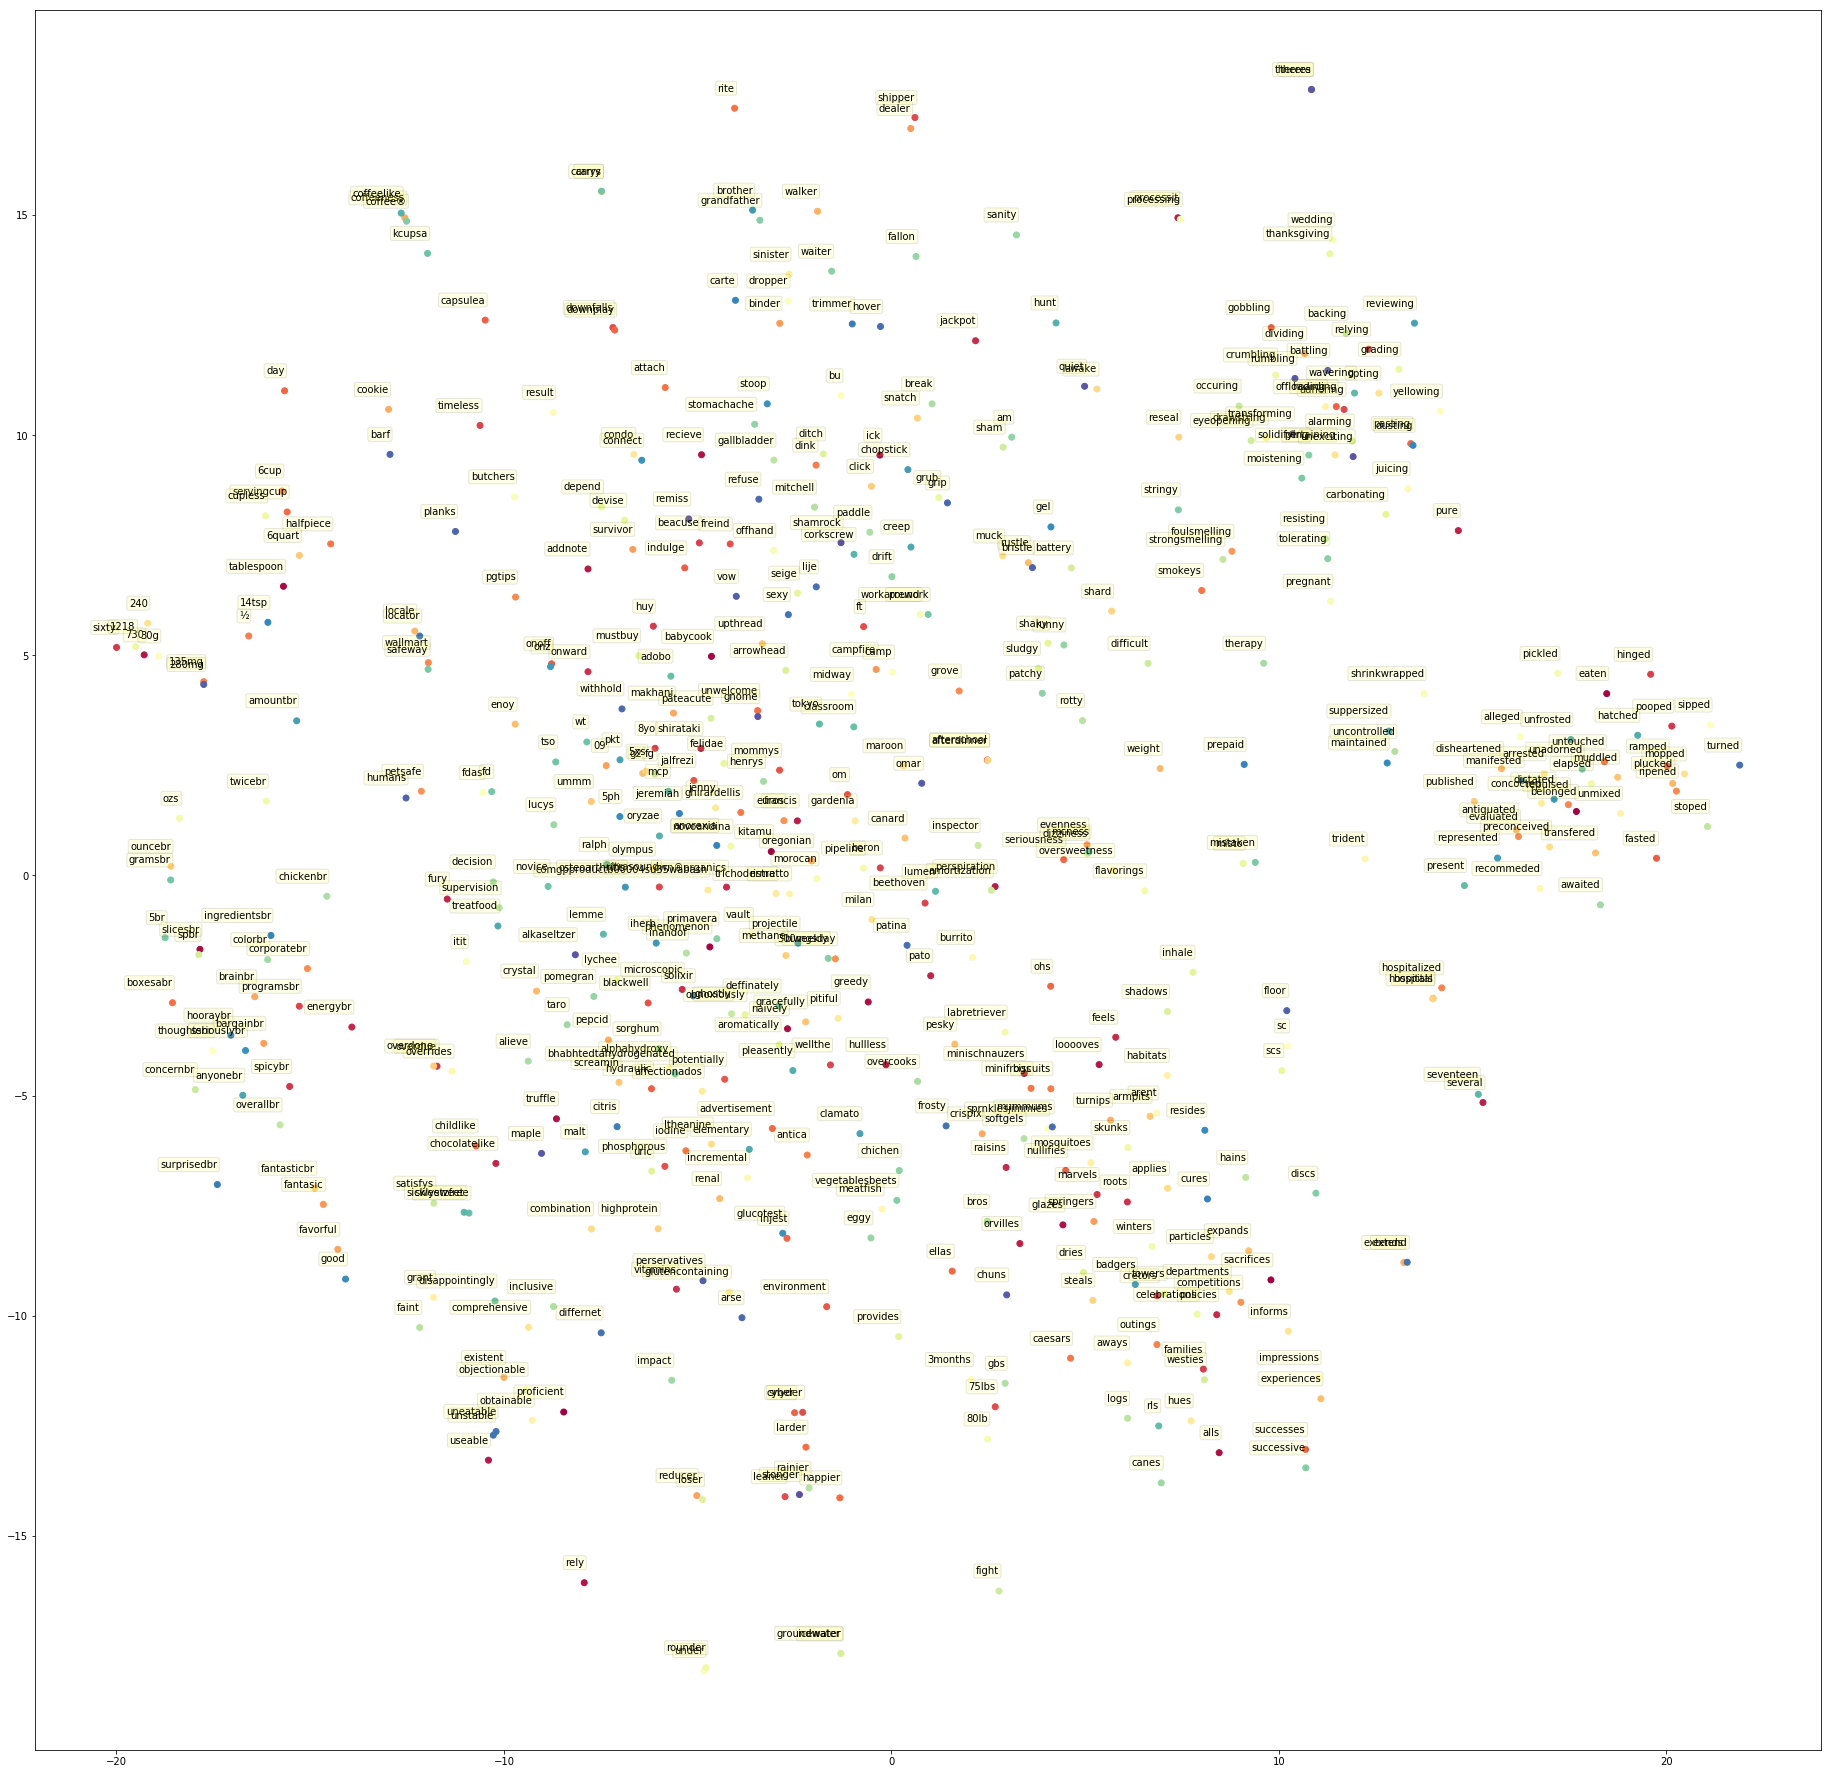

In [52]:
n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate fasttext embeddings of each word
word_vecs = np.array([fasttext_model_wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

## Preparing data as sequences for LSTM

In [53]:
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [ ]:
# for score 

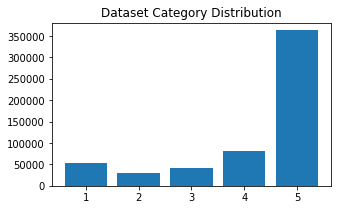

In [54]:
# First let's visualize the distribution of categories in the dataset
categories, ccount = np.unique(df.Score, return_counts=True)

plt.figure(figsize=(5, 3))
plt.title("Dataset Category Distribution")
plt.bar(categories, ccount, align='center')
plt.show()


In [ ]:
df.shape

In [55]:
def word2idx(word):
    try:
        return fasttext_model_wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
    
def idx2word(idx):
    return fasttext_model_wv.index2word[idx]

In [56]:
fasttext_model_wv.index2word[1000]

'hazelnut'

In [57]:
# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored

class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.Score, self.ccount = np.unique(dataset.Score, return_counts=True)
        
        self.seq_length = seq_length
        
    def __iter__(self):
        for review, score in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            # Make all characters lower-case
            review = review.lower()
            
            # Clean string of all punctuation
            review = review.translate(self.translator)

            words = np.array([word2idx(w) for w in review.split(' ')[:self.seq_length] if w != ''])
                                
            # basically what is being done here is this - we take the review and score of a row. 
            # then we send the score intact
            # but, we take the review and split it into an array of words. then those words are searched in the fasttext_model_wv
            # and their index in that model's internal map / dictionary is found. those indexes are saved in an array. 
            # this array is padded with 0 so that these can be of MAX_LENGTH
            # replacing not found elements with 0 doesn't harm as it's the most used word, it will be ignored at some point. 
            
            yield (words, score)

sequences = SequenceIterator(df, MAX_SEQUENCE_LENGTH)

In [ ]:
# d = {1:2,
#     2: 3, 
#     3: 4}
# d

In [58]:
# Used for generating the labels in the set
# cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

# we don't need this dictionary actually as our score field itself contains integer values. 
# although if you want you can name them. 

score_dict = {
                1 : 'Very Bad', 
                2 : 'Bad', 
                3 : 'Medium', 
                4 : 'Good', 
                5 : 'Very Good'
             }

set_x = []
set_y = []

for w, s in sequences:
    set_x.append(w)
#     set_y.append(cat_dict[c])
    set_y.append(s)
    
    
# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

# print(set_x[:10])

In [59]:
# it prints the word back . just for testing. 
#print([[idx2word(idx) for idx in row] for row in set_x[:2]])

set_y

array([5, 1, 4, ..., 5, 5, 5])

In [60]:
# set_x contains a 2-d array. each row has a 200 length array of each review. 
# we didn't break them into sentences or documents to generate this array. 
# we just removed the punctuations and splitted them into words and took first 200 of them 
# and changed them into map index of word2idx. 

# that means, one entry for each review (for us, one entry for each code.)
print(set_x.shape)

# set_y just has the score values serially. 

print(set_y.shape)

(568454, 200)
(568454,)



## Splitting dataset in training and validation

Train Shapes - X: (483186, 200) - Y: (483186,)
Val Shapes - X: (85268, 200) - Y: (85268,)


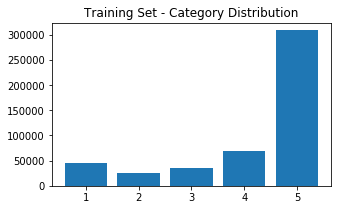

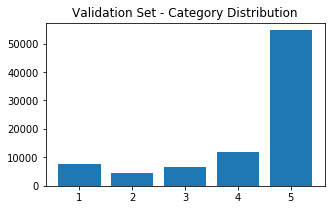

In [90]:
VALID_PER = 0.15 # Percentage of the whole set that will be separated for validation

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Training Set - Category Distribution")
# plt.xticks(range(len(score_dict)), score_dict.values())
plt.bar(categories, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Category Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)

## Defining and Training LSTM Model
A very simple model with a single Bidirectional LSTM layer. A lot more could be done here to improve accuracy and prevent overfitting.

In [78]:
vocab_size, embedding_layer_output_size = ft_weights.shape
print(vocab_size, embedding_layer_output_size)

34867 100


In [89]:
for i in range(len(train_y)): 
    train_y[i] = train_y[i] - 1

for i in range(len(val_y)): 
    val_y[i] = val_y[i] - 1
    

    
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size, # 34867
                    output_dim=embedding_layer_output_size, # 100
                    weights=[ft_weights],
                    input_length=MAX_SEQUENCE_LENGTH, # 200
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(100)))
model.add(Dense(n_categories, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=5, batch_size=64,
                    validation_data=(val_x, val_y), verbose=1)

Train on 483186 samples, validate on 85268 samples
Epoch 1/5


InvalidArgumentError:  Received a label value of -1 which is outside the valid range of [0, 5).  Label values: 3 2 3 3 3 3 3 -1 0 3 3 2 3 3 3 0 3 3 2 3 3 -1 3 1 3 3 1 3 3 3 3 2 3 1 2 0 3 3 2 3 3 3 3 3 2 3 3 3 3 3 3 0 3 0 3 3 3 3 1 3 2 -1 2 3
	 [[node loss_3/dense_7_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_53796]

Function call stack:
keras_scratch_graph


In [ ]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()